Key Facts
1. *flights booked 341 days prior to departure*

In [2]:
# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import warnings

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# SKLEARN
# ------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# XGBOOST
# ------------------------------------------------------
import xgboost as xgb

# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [3]:
# Import
df = pd.read_csv("../data/dataset.csv")
output = pd.read_csv("../data/output.csv")

# Format Date
df['departure_Date'] = pd.to_datetime(df['departure_Date'])
output['departure_Date'] = pd.to_datetime(output['departure_Date'])

df

,departure_Date,Origin_Destination,Target,0_SeatsSold_sum,1_SeatsSold_sum,2_SeatsSold_sum,3_SeatsSold_sum,4_SeatsSold_sum,5_SeatsSold_sum,6_SeatsSold_sum,7_SeatsSold_sum,8_SeatsSold_sum,9_SeatsSold_sum,10_SeatsSold_sum,11_SeatsSold_sum,12_SeatsSold_sum,13_SeatsSold_sum,14_SeatsSold_sum,15_SeatsSold_sum,16_SeatsSold_sum,17_SeatsSold_sum,18_SeatsSold_sum,19_SeatsSold_sum,20_SeatsSold_sum,21_SeatsSold_sum,22_SeatsSold_sum,23_SeatsSold_sum,24_SeatsSold_sum,25_SeatsSold_sum,26_SeatsSold_sum,27_SeatsSold_sum,28_SeatsSold_sum,29_SeatsSold_sum,30_SeatsSold_sum,31_SeatsSold_sum,32_SeatsSold_sum,33_SeatsSold_sum,34_SeatsSold_sum,35_SeatsSold_sum,36_SeatsSold_sum,37_SeatsSold_sum,38_SeatsSold_sum,39_SeatsSold_sum,40_SeatsSold_sum,41_SeatsSold_sum,42_SeatsSold_sum,43_SeatsSold_sum,44_SeatsSold_sum,45_SeatsSold_sum,46_SeatsSold_sum,47_SeatsSold_sum,48_SeatsSold_sum,49_SeatsSold_sum,50_SeatsSold_sum,51_SeatsSold_sum,52_SeatsSold_sum,53_SeatsSold_sum,54_SeatsSold_sum,55_SeatsSold_sum,56_SeatsSold_sum,57_SeatsSold_sum,58_SeatsSold_sum,59_SeatsSold_sum,60_SeatsSold_sum,61_SeatsSold_sum,62_SeatsSold_sum,63_SeatsSold_sum,64_SeatsSold_sum,65_SeatsSold_sum,66_SeatsSold_sum,67_SeatsSold_sum,68_SeatsSold_sum,69_SeatsSold_sum,70_SeatsSold_sum,71_SeatsSold_sum,72_SeatsSold_sum,73_SeatsSold_sum,74_SeatsSold_sum,75_SeatsSold_sum,76_SeatsSold_sum,77_SeatsSold_sum,78_SeatsSold_sum,79_SeatsSold_sum,80_SeatsSold_sum,81_SeatsSold_sum,82_SeatsSold_sum,83_SeatsSold_sum,84_SeatsSold_sum,85_SeatsSold_sum,86_SeatsSold_sum,87_SeatsSold_sum,88_SeatsSold_sum,89_SeatsSold_sum,90_SeatsSold_sum,91_SeatsSold_sum,92_SeatsSold_sum,93_SeatsSold_sum,94_SeatsSold_sum,95_SeatsSold_sum,96_SeatsSold_sum,97_SeatsSold_sum,98_SeatsSold_sum,99_SeatsSold_sum,100_SeatsSold_sum,101_SeatsSold_sum,102_SeatsSold_sum,103_SeatsSold_sum,104_SeatsSold_sum,105_SeatsSold_sum,106_SeatsSold_sum,107_SeatsSold_sum,108_SeatsSold_sum,109_SeatsSold_sum,110_SeatsSold_sum,111_SeatsSold_sum,112_SeatsSold_sum,113_SeatsSold_sum,114_SeatsSold_sum,115_SeatsSold_sum,116_SeatsSold_sum,117_SeatsSold_sum,118_SeatsSold_sum,119_SeatsSold_sum,120_SeatsSold_sum,121_SeatsSold_sum,122_SeatsSold_sum,123_SeatsSold_sum,124_SeatsSold_sum,125_SeatsSold_sum,126_SeatsSold_sum,127_SeatsSold_sum,128_SeatsSold_sum,129_SeatsSold_sum,130_SeatsSold_sum,131_SeatsSold_sum,132_SeatsSold_sum,133_SeatsSold_sum,134_SeatsSold_sum,135_SeatsSold_sum,136_SeatsSold_sum,137_SeatsSold_sum,138_SeatsSold_sum,139_SeatsSold_sum,140_SeatsSold_sum,141_SeatsSold_sum,142_SeatsSold_sum,143_SeatsSold_sum,144_SeatsSold_sum,145_SeatsSold_sum,146_SeatsSold_sum,147_SeatsSold_sum,148_SeatsSold_sum,149_SeatsSold_sum,150_SeatsSold_sum,151_SeatsSold_sum,152_SeatsSold_sum,153_SeatsSold_sum,154_SeatsSold_sum,155_SeatsSold_sum,156_SeatsSold_sum,157_SeatsSold_sum,158_SeatsSold_sum,159_SeatsSold_sum,160_SeatsSold_sum,161_SeatsSold_sum,162_SeatsSold_sum,163_SeatsSold_sum,164_SeatsSold_sum,165_SeatsSold_sum,166_SeatsSold_sum,167_SeatsSold_sum,168_SeatsSold_sum,169_SeatsSold_sum,170_SeatsSold_sum,171_SeatsSold_sum,172_SeatsSold_sum,173_SeatsSold_sum,174_SeatsSold_sum,175_SeatsSold_sum,176_SeatsSold_sum,177_SeatsSold_sum,178_SeatsSold_sum,179_SeatsSold_sum,180_SeatsSold_sum,181_SeatsSold_sum,182_SeatsSold_sum,183_SeatsSold_sum,184_SeatsSold_sum,185_SeatsSold_sum,186_SeatsSold_sum,187_SeatsSold_sum,188_SeatsSold_sum,189_SeatsSold_sum,190_SeatsSold_sum,191_SeatsSold_sum,192_SeatsSold_sum,193_SeatsSold_sum,194_SeatsSold_sum,195_SeatsSold_sum,196_SeatsSold_sum,197_SeatsSold_sum,198_SeatsSold_sum,199_SeatsSold_sum,200_SeatsSold_sum,201_SeatsSold_sum,202_SeatsSold_sum,203_SeatsSold_sum,204_SeatsSold_sum,205_SeatsSold_sum,206_SeatsSold_sum,207_SeatsSold_sum,208_SeatsSold_sum,209_SeatsSold_sum,210_SeatsSold_sum,211_SeatsSold_sum,212_SeatsSold_sum,213_SeatsSold_sum,214_SeatsSold_sum,215_SeatsSold_sum,216_SeatsSold_sum,217_SeatsSold_sum,218_SeatsSold_sum,219_SeatsSold_sum,220_SeatsSold_sum,221_SeatsSold_sum,222_SeatsSold_sum,223_SeatsSold_sum,224_SeatsSold_sum,225_SeatsSold_sum,

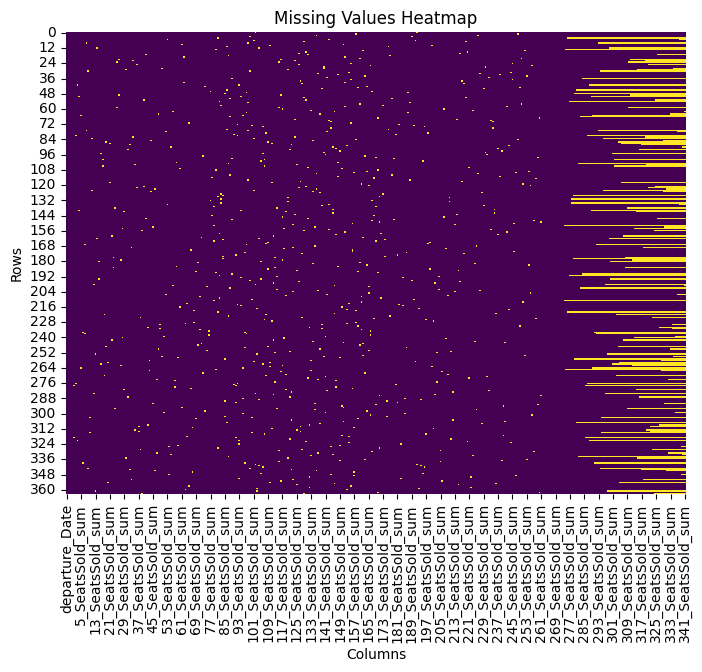

In [3]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis') # cbar=False removes the color bar
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [4]:
# Melting Seats Sold
id_vars = ['departure_Date', 'Origin_Destination', 'Target']
value_vars = [col for col in df.columns if '_SeatsSold_sum' in col]
df_melted = df.melt(id_vars=id_vars, value_vars=value_vars, var_name='days_before_departure_str', value_name='seats_sold')
df_melted['days_before_departure'] = df_melted['days_before_departure_str'].str.extract('(\d+)').astype(int)
df_processed = df_melted.drop(columns=['days_before_departure_str'])
df_processed = pd.get_dummies(df_processed, columns=['Origin_Destination'], prefix='OD')
df_processed


,departure_Date,Target,seats_sold,days_before_departure,OD_DXB-XXX,OD_XXX-DXB
0,2022-09-22 00:00:00+00:00,466,466.00,0,True,False
1,2022-11-17 00:00:00+00:00,314,314.00,0,True,False
2,2022-10-26 00:00:00+00:00,431,431.00,0,True,False
3,2022-09-19 00:00:00+00:00,385,385.00,0,True,False
4,2022-06-03 00:00:00+00:00,507,507.00,0,False,True
...,...,...,...,...,...,...
124483,2022-09-23 00:00:00+00:00,491,0.00,341,False,True
124484,2022-08-14 00:00:00+00:00,494,0.00,341,True,False
124485,2022-06-25 00:00:00+00:00,509,NaN,341,False,True
124486,2022-11-29 00:00:00+00:00,436,0.00,341,True,False


In [ ]:
def plot_days_before_departure(df, plot_type='line', value_column='seats_sold'):
    """
    Generates a line graph or scatter plot of seats_sold vs. days_before_departure,
    with different colors for each unique departure_date.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
                          Expected columns: 'days_before_departure', 'seats_sold', 'departure_date'.
        plot_type (str): Type of plot to generate. Can be 'line' or 'scatter'.
                         Defaults to 'line'.
    """
    if not all(col in df.columns for col in ['days_before_departure', 'seats_sold', 'departure_Date']):
        print("Error: DataFrame must contain 'days_before_departure', 'seats_sold', and 'departure_Date' columns.")
        return


    df['departure_Date'] = pd.to_datetime(df['departure_Date']).dt.date 
    df['OD_Route'] = df.apply(lambda row: f"{row['departure_Date']} | DXB-XXX:{row['OD_DXB-XXX']} | XXX-DXB:{row['OD_XXX-DXB']}", axis=1)

    plt.figure(figsize=(12, 7))

    if plot_type == 'line':
        sns.lineplot(
            data=df,
            x='days_before_departure',
            y=value_column,
            hue='OD_Route',
            marker='o', 
            dashes=False,
            alpha=0.7 
        )
        plt.title('Seats Sold vs. Days Before Departure by Departure Date (Line Plot)')
    elif plot_type == 'scatter':
        sns.scatterplot(
            data=df,
            x='days_before_departure',
            y=value_column,
            hue='OD_Route',
            s=50, 
            alpha=0.7
        )
        plt.title('Seats Sold vs. Days Before Departure by Departure Date (Scatter Plot)')
    else:
        print("Invalid plot_type. Please choose 'line' or 'scatter'.")
        return

    plt.xlabel('Days Before Departure')
    plt.ylabel('Seats Sold')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title='Departure Date | OD_Route', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout() 
    plt.show()

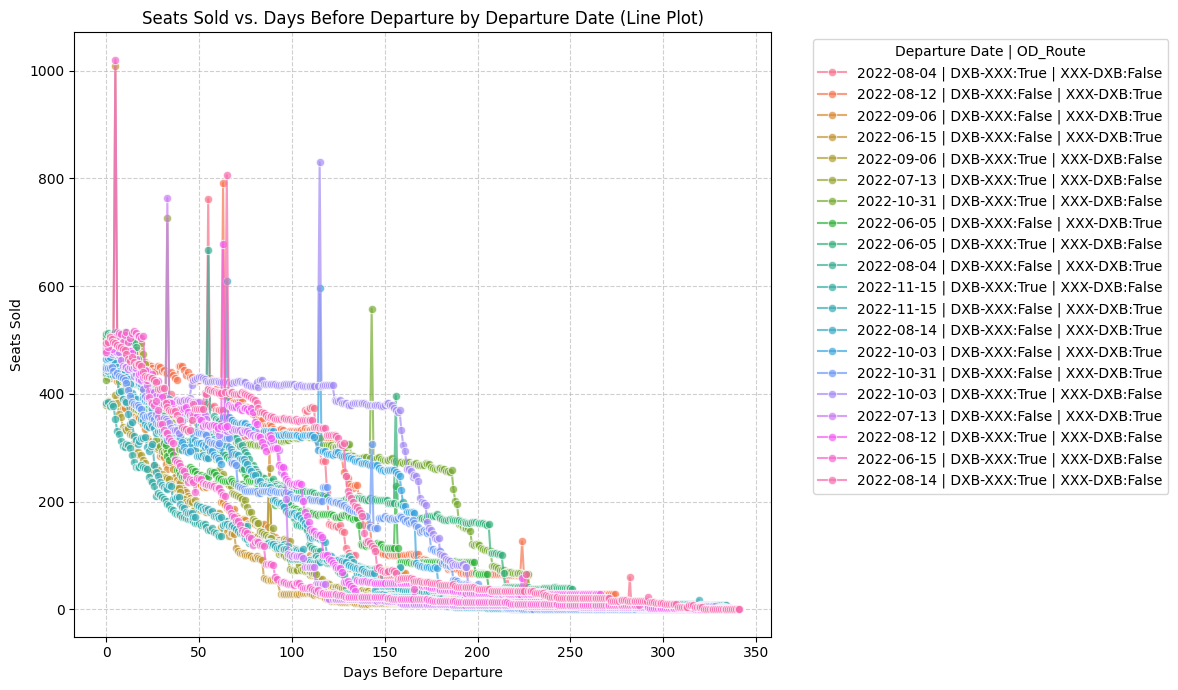

In [6]:
l = df_processed['departure_Date'].sample(10)
df_sampled = df_processed[df_processed['departure_Date'].isin(l)]
plot_days_before_departure(df_sampled, plot_type='line', value_column='seats_sold')

In [6]:
def impute_wide_format_sales(df):
    """
    Fills contiguous blocks of NaN with 0.

    Args:
        df (pd.DataFrame): The wide-format DataFrame with sales data.
                            Expected columns: 'departure_Date', 'Origin_Destination', 'Target',
                            and '{day_idx}_SeatsSold_sum' columns.
    Returns:
        pd.DataFrame: DataFrame with imputed missing values.
    """

    # Identify sales columns
    sales_cols = [col for col in df.columns if '_SeatsSold_sum' in col]

    for index, row in df.iterrows():
        sales_data = row[sales_cols]

        # Step 1: Fill contiguous blocks of NaNs with 0
        current_sales_series = pd.Series(sales_data.values, index=[int(c.split('_')[0]) for c in sales_cols])
        current_sales_series = current_sales_series.sort_index(ascending=False) # Sort by days_before_departure descending

        fill_zero_until_first_sale = True
        for day_idx in current_sales_series.index:
            col_name = f'{day_idx}_SeatsSold_sum'
            if pd.isna(df.loc[index, col_name]):
                if fill_zero_until_first_sale:
                    df.loc[index, col_name] = 0
            else:
                fill_zero_until_first_sale = False
        
    return df

In [7]:
df_imputed = impute_wide_format_sales(df)
df_imputed

,departure_Date,Origin_Destination,Target,0_SeatsSold_sum,1_SeatsSold_sum,2_SeatsSold_sum,3_SeatsSold_sum,4_SeatsSold_sum,5_SeatsSold_sum,6_SeatsSold_sum,7_SeatsSold_sum,8_SeatsSold_sum,9_SeatsSold_sum,10_SeatsSold_sum,11_SeatsSold_sum,12_SeatsSold_sum,13_SeatsSold_sum,14_SeatsSold_sum,15_SeatsSold_sum,16_SeatsSold_sum,17_SeatsSold_sum,18_SeatsSold_sum,19_SeatsSold_sum,20_SeatsSold_sum,21_SeatsSold_sum,22_SeatsSold_sum,23_SeatsSold_sum,24_SeatsSold_sum,25_SeatsSold_sum,26_SeatsSold_sum,27_SeatsSold_sum,28_SeatsSold_sum,29_SeatsSold_sum,30_SeatsSold_sum,31_SeatsSold_sum,32_SeatsSold_sum,33_SeatsSold_sum,34_SeatsSold_sum,35_SeatsSold_sum,36_SeatsSold_sum,37_SeatsSold_sum,38_SeatsSold_sum,39_SeatsSold_sum,40_SeatsSold_sum,41_SeatsSold_sum,42_SeatsSold_sum,43_SeatsSold_sum,44_SeatsSold_sum,45_SeatsSold_sum,46_SeatsSold_sum,47_SeatsSold_sum,48_SeatsSold_sum,49_SeatsSold_sum,50_SeatsSold_sum,51_SeatsSold_sum,52_SeatsSold_sum,53_SeatsSold_sum,54_SeatsSold_sum,55_SeatsSold_sum,56_SeatsSold_sum,57_SeatsSold_sum,58_SeatsSold_sum,59_SeatsSold_sum,60_SeatsSold_sum,61_SeatsSold_sum,62_SeatsSold_sum,63_SeatsSold_sum,64_SeatsSold_sum,65_SeatsSold_sum,66_SeatsSold_sum,67_SeatsSold_sum,68_SeatsSold_sum,69_SeatsSold_sum,70_SeatsSold_sum,71_SeatsSold_sum,72_SeatsSold_sum,73_SeatsSold_sum,74_SeatsSold_sum,75_SeatsSold_sum,76_SeatsSold_sum,77_SeatsSold_sum,78_SeatsSold_sum,79_SeatsSold_sum,80_SeatsSold_sum,81_SeatsSold_sum,82_SeatsSold_sum,83_SeatsSold_sum,84_SeatsSold_sum,85_SeatsSold_sum,86_SeatsSold_sum,87_SeatsSold_sum,88_SeatsSold_sum,89_SeatsSold_sum,90_SeatsSold_sum,91_SeatsSold_sum,92_SeatsSold_sum,93_SeatsSold_sum,94_SeatsSold_sum,95_SeatsSold_sum,96_SeatsSold_sum,97_SeatsSold_sum,98_SeatsSold_sum,99_SeatsSold_sum,100_SeatsSold_sum,101_SeatsSold_sum,102_SeatsSold_sum,103_SeatsSold_sum,104_SeatsSold_sum,105_SeatsSold_sum,106_SeatsSold_sum,107_SeatsSold_sum,108_SeatsSold_sum,109_SeatsSold_sum,110_SeatsSold_sum,111_SeatsSold_sum,112_SeatsSold_sum,113_SeatsSold_sum,114_SeatsSold_sum,115_SeatsSold_sum,116_SeatsSold_sum,117_SeatsSold_sum,118_SeatsSold_sum,119_SeatsSold_sum,120_SeatsSold_sum,121_SeatsSold_sum,122_SeatsSold_sum,123_SeatsSold_sum,124_SeatsSold_sum,125_SeatsSold_sum,126_SeatsSold_sum,127_SeatsSold_sum,128_SeatsSold_sum,129_SeatsSold_sum,130_SeatsSold_sum,131_SeatsSold_sum,132_SeatsSold_sum,133_SeatsSold_sum,134_SeatsSold_sum,135_SeatsSold_sum,136_SeatsSold_sum,137_SeatsSold_sum,138_SeatsSold_sum,139_SeatsSold_sum,140_SeatsSold_sum,141_SeatsSold_sum,142_SeatsSold_sum,143_SeatsSold_sum,144_SeatsSold_sum,145_SeatsSold_sum,146_SeatsSold_sum,147_SeatsSold_sum,148_SeatsSold_sum,149_SeatsSold_sum,150_SeatsSold_sum,151_SeatsSold_sum,152_SeatsSold_sum,153_SeatsSold_sum,154_SeatsSold_sum,155_SeatsSold_sum,156_SeatsSold_sum,157_SeatsSold_sum,158_SeatsSold_sum,159_SeatsSold_sum,160_SeatsSold_sum,161_SeatsSold_sum,162_SeatsSold_sum,163_SeatsSold_sum,164_SeatsSold_sum,165_SeatsSold_sum,166_SeatsSold_sum,167_SeatsSold_sum,168_SeatsSold_sum,169_SeatsSold_sum,170_SeatsSold_sum,171_SeatsSold_sum,172_SeatsSold_sum,173_SeatsSold_sum,174_SeatsSold_sum,175_SeatsSold_sum,176_SeatsSold_sum,177_SeatsSold_sum,178_SeatsSold_sum,179_SeatsSold_sum,180_SeatsSold_sum,181_SeatsSold_sum,182_SeatsSold_sum,183_SeatsSold_sum,184_SeatsSold_sum,185_SeatsSold_sum,186_SeatsSold_sum,187_SeatsSold_sum,188_SeatsSold_sum,189_SeatsSold_sum,190_SeatsSold_sum,191_SeatsSold_sum,192_SeatsSold_sum,193_SeatsSold_sum,194_SeatsSold_sum,195_SeatsSold_sum,196_SeatsSold_sum,197_SeatsSold_sum,198_SeatsSold_sum,199_SeatsSold_sum,200_SeatsSold_sum,201_SeatsSold_sum,202_SeatsSold_sum,203_SeatsSold_sum,204_SeatsSold_sum,205_SeatsSold_sum,206_SeatsSold_sum,207_SeatsSold_sum,208_SeatsSold_sum,209_SeatsSold_sum,210_SeatsSold_sum,211_SeatsSold_sum,212_SeatsSold_sum,213_SeatsSold_sum,214_SeatsSold_sum,215_SeatsSold_sum,216_SeatsSold_sum,217_SeatsSold_sum,218_SeatsSold_sum,219_SeatsSold_sum,220_SeatsSold_sum,221_SeatsSold_sum,222_SeatsSold_sum,223_SeatsSold_sum,224_SeatsSold_sum,225_SeatsSold_sum,

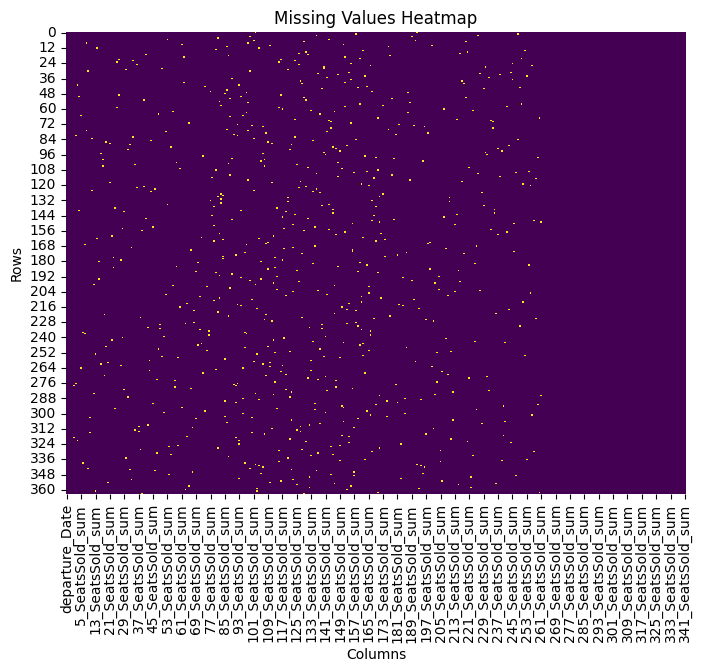

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_imputed.isnull(), cbar=False, cmap='viridis') 
plt.title('Missing Values Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

In [9]:
def correct_outliers_missing(df, window_size=7, std_multiplier=2):
    """
    Corrects outliers and missing values in the 'seats_sold' column of a DataFrame based on
    a rolling mean +/- a standard deviation multiplier for outlier detection.

    Imputation method: Fill with the average of the nearest valid (non-outlier, non-NaN) preceding
    and succeeding 'seats_sold' values for that specific 'departure_Date' and OD combination.
    Corrected values are whole numbers. If only one valid neighbor is found, that value is used.
    If no valid neighbors are found, the value defaults to 0.

    Args:
        df (pd.DataFrame): The input DataFrame. Expected columns:
                           'departure_Date', 'days_before_departure', 'seats_sold', 'Target',
                           'OD_DXB-XXX', 'OD_XXX-DXB'.
        window_size (int): The size of the rolling window for mean and std calculation.
                           Defaults to 7 (for a 7-day rolling window).
        std_multiplier (int or float): The number of standard deviations to consider
                                       for the upper and lower bounds. Defaults to 2.

    Returns:
        pd.DataFrame: A new DataFrame with corrected 'seats_sold' values.
    """

    df_corrected = df.copy()

    df_corrected = df_corrected.sort_values(
        by=['departure_Date', 'OD_DXB-XXX', 'OD_XXX-DXB', 'days_before_departure'],
        ascending=[True, True, True, False] 
    ).reset_index(drop=True)

    df_corrected['corrected_seats_sold'] = df_corrected['seats_sold'] 
    df_corrected['is_impute_candidate_flag'] = False 

    # Group by departure_Date and OD columns
    for group_keys, group in df_corrected.groupby(['departure_Date', 'OD_DXB-XXX', 'OD_XXX-DXB']):
        rolling_mean = group['seats_sold'].rolling(window=window_size, min_periods=1).mean()
        rolling_std = group['seats_sold'].rolling(window=window_size, min_periods=1).std()

        upper_bound = rolling_mean + std_multiplier * rolling_std
        lower_bound = rolling_mean - std_multiplier * rolling_std

        # Identify values that are missing OR outliers
        imputation_candidates_indices = []
        for i in range(len(group)):
            original_row_index = group.index[i]
            current_seats_sold = group.loc[original_row_index, 'seats_sold'] 

            is_missing = pd.isna(current_seats_sold)
            is_outlier = False

            if not is_missing and np.isfinite(upper_bound.iloc[i]) and np.isfinite(lower_bound.iloc[i]):
                if not (lower_bound.iloc[i] <= current_seats_sold <= upper_bound.iloc[i]):
                    is_outlier = True
            
            if is_missing or is_outlier:
                df_corrected.loc[original_row_index, 'is_impute_candidate_flag'] = True
                imputation_candidates_indices.append(original_row_index)

        # Now iterate through the identified candidates to impute
        for original_row_index in imputation_candidates_indices:
            current_days_before_departure = df_corrected.loc[original_row_index, 'days_before_departure']

            # Find nearest non-candidate preceding value from the *original* 'seats_sold' series of the group
            preceding_valid_values = group[
                (group['days_before_departure'] > current_days_before_departure) &
                (~df_corrected.loc[group.index, 'is_impute_candidate_flag']) 
            ]
            preceding_valid_sold = np.nan
            if not preceding_valid_values.empty:
                closest_preceding_row = preceding_valid_values.sort_values(by='days_before_departure', ascending=True).iloc[0]
                preceding_valid_sold = closest_preceding_row['seats_sold']


            # Find nearest non-candidate succeeding value from the *original* 'seats_sold' series of the group
            succeeding_valid_values = group[
                (group['days_before_departure'] < current_days_before_departure) &
                (~df_corrected.loc[group.index, 'is_impute_candidate_flag']) 
            ]
            succeeding_valid_sold = np.nan
            if not succeeding_valid_values.empty:
                closest_succeeding_row = succeeding_valid_values.sort_values(by='days_before_departure', ascending=False).iloc[0]
                succeeding_valid_sold = closest_succeeding_row['seats_sold']

            
            # Apply imputation based on found valid neighbors
            values_to_average = []
            if not pd.isna(preceding_valid_sold):
                values_to_average.append(preceding_valid_sold)
            if not pd.isna(succeeding_valid_sold):
                values_to_average.append(succeeding_valid_sold)
            
            if values_to_average:
                # Average found valid neighbors
                df_corrected.loc[original_row_index, 'corrected_seats_sold'] = int(np.round(np.mean(values_to_average)))
            else:
                # If no valid neighbors found, fall back to 0
                df_corrected.loc[original_row_index, 'corrected_seats_sold'] = 0

    return df_corrected

In [10]:
# Melting Seats Sold
id_vars = ['departure_Date', 'Origin_Destination', 'Target']
value_vars = [col for col in df_imputed.columns if '_SeatsSold_sum' in col]
df_melted = df_imputed.melt(id_vars=id_vars, value_vars=value_vars, var_name='days_before_departure_str', value_name='seats_sold')
df_melted['days_before_departure'] = df_melted['days_before_departure_str'].str.extract('(\d+)').astype(int)
df_processed = df_melted.drop(columns=['days_before_departure_str'])
df_processed = pd.get_dummies(df_processed, columns=['Origin_Destination'], prefix='OD')
df_processed

,departure_Date,Target,seats_sold,days_before_departure,OD_DXB-XXX,OD_XXX-DXB
0,2022-09-22 00:00:00+00:00,466,466.00,0,True,False
1,2022-11-17 00:00:00+00:00,314,314.00,0,True,False
2,2022-10-26 00:00:00+00:00,431,431.00,0,True,False
3,2022-09-19 00:00:00+00:00,385,385.00,0,True,False
4,2022-06-03 00:00:00+00:00,507,507.00,0,False,True
...,...,...,...,...,...,...
124483,2022-09-23 00:00:00+00:00,491,0.00,341,False,True
124484,2022-08-14 00:00:00+00:00,494,0.00,341,True,False
124485,2022-06-25 00:00:00+00:00,509,0.00,341,False,True
124486,2022-11-29 00:00:00+00:00,436,0.00,341,True,False


In [11]:
df_training = correct_outliers_missing(df_processed, window_size=7, std_multiplier=2)
df_training

,departure_Date,Target,seats_sold,days_before_departure,OD_DXB-XXX,OD_XXX-DXB,corrected_seats_sold,is_impute_candidate_flag
0,2022-06-01 00:00:00+00:00,505,0.00,341,False,True,0.00,False
1,2022-06-01 00:00:00+00:00,505,0.00,340,False,True,0.00,False
2,2022-06-01 00:00:00+00:00,505,0.00,339,False,True,0.00,False
3,2022-06-01 00:00:00+00:00,505,0.00,338,False,True,0.00,False
4,2022-06-01 00:00:00+00:00,505,0.00,337,False,True,0.00,False
...,...,...,...,...,...,...,...,...
124483,2022-11-30 00:00:00+00:00,372,370.00,4,True,False,370.00,False
124484,2022-11-30 00:00:00+00:00,372,368.00,3,True,False,368.00,False
124485,2022-11-30 00:00:00+00:00,372,364.00,2,True,False,364.00,False
124486,2022-11-30 00:00:00+00:00,372,371.00,1,True,False,371.00,False


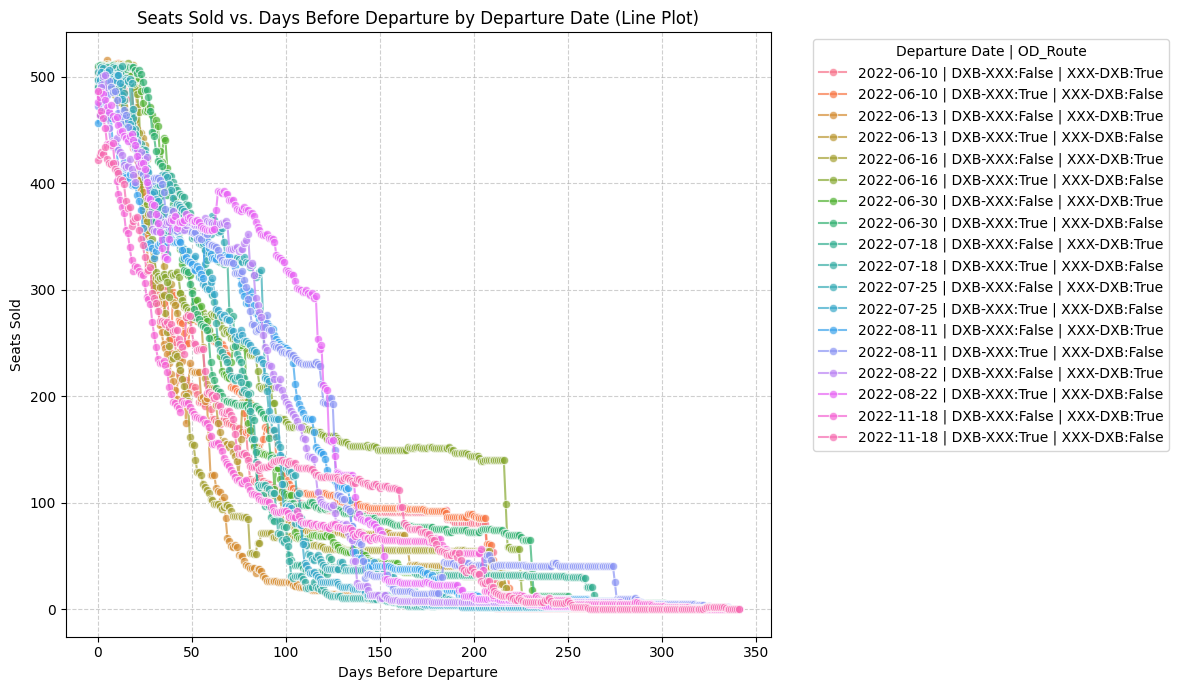

In [14]:
l = df_processed['departure_Date'].sample(10)
df_sampled = df_training[df_training['departure_Date'].isin(l)]
plot_days_before_departure(df_sampled, plot_type='line', value_column='corrected_seats_sold')

In [15]:
def feature_engineering(df):

    # Features from departure_Date
    df['day_of_week'] = df['departure_Date'].dt.dayofweek
    df['day_of_year'] = df['departure_Date'].dt.dayofyear
    df['day'] = df['departure_Date'].dt.day
    df['month'] = df['departure_Date'].dt.month
    df['year'] = df['departure_Date'].dt.year
    df['quarter'] = df['departure_Date'].dt.quarter
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    df['week_of_year'] = df['departure_Date'].dt.isocalendar().week.astype(int)
    df['days_x_month'] = df['days_before_departure'] * df['month']

    if 'OD_DXB-XXX' in df.columns:
        df_processed['OD_DXB-XXX'] = df_processed['OD_DXB-XXX'].astype(int)
    if 'OD_XXX_DXB' in df_processed.columns:
        df_processed['OD_XXX_DXB'] = df_processed['OD_XXX-DXB'].astype(int)

    df['lag_1_corrected_seats_sold'] = df.groupby(
        ['departure_Date', 'OD_DXB-XXX', 'OD_XXX-DXB', 'Target']
    )['corrected_seats_sold'].shift(1)

    df['lag_2_corrected_seats_sold'] = df.groupby(
        ['departure_Date', 'OD_DXB-XXX', 'OD_XXX-DXB', 'Target']
    )['corrected_seats_sold'].shift(2)

    df['lag_7_corrected_seats_sold'] = df.groupby(
        ['departure_Date', 'OD_DXB-XXX', 'OD_XXX-DXB', 'Target']
    )['corrected_seats_sold'].shift(7)

    df['lag_1_corrected_seats_sold'] = df['lag_1_corrected_seats_sold'].fillna(0)
    df['lag_2_corrected_seats_sold'] = df['lag_2_corrected_seats_sold'].fillna(0)
    df['lag_7_corrected_seats_sold'] = df['lag_7_corrected_seats_sold'].fillna(0)

    return df


In [16]:
df_training = feature_engineering(df_training)  
df_training

,departure_Date,Target,seats_sold,days_before_departure,OD_DXB-XXX,OD_XXX-DXB,corrected_seats_sold,is_impute_candidate_flag,day_of_week,day_of_year,day,month,year,quarter,is_weekend,week_of_year,days_x_month,lag_1_corrected_seats_sold,lag_2_corrected_seats_sold,lag_7_corrected_seats_sold
0,2022-06-01 00:00:00+00:00,505,0.00,341,False,True,0.00,False,2,152,1,6,2022,2,0,22,2046,0.00,0.00,0.00
1,2022-06-01 00:00:00+00:00,505,0.00,340,False,True,0.00,False,2,152,1,6,2022,2,0,22,2040,0.00,0.00,0.00
2,2022-06-01 00:00:00+00:00,505,0.00,339,False,True,0.00,False,2,152,1,6,2022,2,0,22,2034,0.00,0.00,0.00
3,2022-06-01 00:00:00+00:00,505,0.00,338,False,True,0.00,False,2,152,1,6,2022,2,0,22,2028,0.00,0.00,0.00
4,2022-06-01 00:00:00+00:00,505,0.00,337,False,True,0.00,False,2,152,1,6,2022,2,0,22,2022,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124483,2022-11-30 00:00:00+00:00,372,370.00,4,True,False,370.00,False,2,334,30,11,2022,4,0,48,44,366.00,370.00,357.00
124484,2022-11-30 00:00:00+00:00,372,368.00,3,True,False,368.00,False,2,334,30,11,2022,4,0,48,33,370.00,366.00,359.00
124485,2022-11-30 00:00:00+00:00,372,364.00,2,True,False,364.00,False,2,334,30,11,2022,4,0,48,22,368.00,370.00,354.00
124486,2022-11-30 00:00:00+00:00,372,371.00,1,True,False,371.00,False,2,334,30,11,2022,4,0,48,11,364.00,368.00,344.00


In [57]:

# Model Training

# X and y
features = [col for col in df_training.columns if col not in ['departure_Date', 'seats_sold','corrected_seats_sold','is_impute_candidate_flag']]
X = df_training[features]
y = df_training['corrected_seats_sold']

for col in ['OD_DXB-XXX', 'OD_XXX-DXB']:
    if col in X.columns and X[col].dtype == bool:
        X[col] = X[col].astype(int)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# XGBoost Model Training

print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         learning_rate=0.05,
                         random_state=42,
                         n_jobs=-1,
                         eval_metric='rmse', 
                         early_stopping_rounds=50 
                        )

xgb_model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=False
         )

xgb_predictions = xgb_model.predict(X_val)

print("Model training complete.")

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
xgb_mae = mean_absolute_error(y_val, xgb_predictions)
xgb_r2 = r2_score(y_val, xgb_predictions)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost R-squared: {xgb_r2:.2f}")

# --- Random Forest Model ---
print("\n--- Training Random Forest model ---")
rf_model = RandomForestRegressor(n_estimators=1000,
                                 random_state=42,
                                 n_jobs=-1,
                                 oob_score=True # Calculate out-of-bag score
                                )

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_predictions))
rf_mae = mean_absolute_error(y_val, rf_predictions)
rf_r2 = r2_score(y_val, rf_predictions)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest R-squared: {rf_r2:.2f}")

print("\n--- Model Comparison ---")
print(f"{'Metric':<15} {'XGBoost':<15} {'Random Forest':<15}")
print(f"{'RMSE':<15} {xgb_rmse:<15.2f} {rf_rmse:<15.2f}")
print(f"{'MAE':<15} {xgb_mae:<15.2f} {rf_mae:<15.2f}")
print(f"{'R-squared':<15} {xgb_r2:<15.2f} {rf_r2:<15.2f}")


Training data shape: (99590, 16)
Validation data shape: (24898, 16)
Training XGBoost model...
Model training complete.
XGBoost RMSE: 4.93
XGBoost MAE: 2.20
XGBoost R-squared: 1.00

--- Training Random Forest model ---
Random Forest RMSE: 5.16
Random Forest MAE: 2.23
Random Forest R-squared: 1.00

--- Model Comparison ---
Metric          XGBoost         Random Forest  
RMSE            4.93            5.16           
MAE             2.20            2.23           
R-squared       1.00            1.00           


In [58]:

# Model Training

# X and y
features = [col for col in df_training.columns if col not in ['departure_Date', 'seats_sold','corrected_seats_sold','is_impute_candidate_flag']]
X = df_training[features]
y = df_training['seats_sold']
y.fillna(0, inplace=True)

for col in ['OD_DXB-XXX', 'OD_XXX-DXB']:
    if col in X.columns and X[col].dtype == bool:
        X[col] = X[col].astype(int)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# XGBoost Model Training

print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         learning_rate=0.05,
                         random_state=42,
                         n_jobs=-1,
                         eval_metric='rmse', 
                         early_stopping_rounds=50 
                        )

xgb_model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=False
         )

xgb_predictions = xgb_model.predict(X_val)

print("Model training complete.")

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
xgb_mae = mean_absolute_error(y_val, xgb_predictions)
xgb_r2 = r2_score(y_val, xgb_predictions)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost R-squared: {xgb_r2:.2f}")

# --- Random Forest Model ---
print("\n--- Training Random Forest model ---")
rf_model = RandomForestRegressor(n_estimators=1000,
                                 random_state=42,
                                 n_jobs=-1,
                                 oob_score=True # Calculate out-of-bag score
                                )

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_predictions))
rf_mae = mean_absolute_error(y_val, rf_predictions)
rf_r2 = r2_score(y_val, rf_predictions)

print(f"Random Forest RMSE: {rf_rmse:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}")
print(f"Random Forest R-squared: {rf_r2:.2f}")

print("\n--- Model Comparison ---")
print(f"{'Metric':<15} {'XGBoost':<15} {'Random Forest':<15}")
print(f"{'RMSE':<15} {xgb_rmse:<15.2f} {rf_rmse:<15.2f}")
print(f"{'MAE':<15} {xgb_mae:<15.2f} {rf_mae:<15.2f}")
print(f"{'R-squared':<15} {xgb_r2:<15.2f} {rf_r2:<15.2f}")


Training data shape: (99590, 16)
Validation data shape: (24898, 16)
Training XGBoost model...
Model training complete.
XGBoost RMSE: 24.81
XGBoost MAE: 4.87
XGBoost R-squared: 0.97

--- Training Random Forest model ---
Random Forest RMSE: 27.07
Random Forest MAE: 5.59
Random Forest R-squared: 0.97

--- Model Comparison ---
Metric          XGBoost         Random Forest  
RMSE            24.81           27.07          
MAE             4.87            5.59           
R-squared       0.97            0.97           


In [17]:

# Model Training

# X and y
features = [col for col in df_training.columns if col not in ['departure_Date', 'seats_sold','corrected_seats_sold','is_impute_candidate_flag']]
X = df_training[features]
y = df_training['corrected_seats_sold']

for col in ['OD_DXB-XXX', 'OD_XXX-DXB']:
    if col in X.columns and X[col].dtype == bool:
        X[col] = X[col].astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) 

print(f"Full data shape: {X.shape}")
print(f"Training data shape for tuning: {X_train.shape}")
print(f"Validation data shape for tuning (used by eval_set/callbacks): {X_val.shape}")
print(f"Hold-out Test data shape (for final evaluation): {X_test.shape}")

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)


# --- XGBoost Model Training with GridSearchCV ---
print("\n--- Hyperparameter Tuning and Cross-Validation for XGBoost ---")

param_grid_xgb = {
    'n_estimators': [500, 1000], 
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'gamma': [0, 0.1]
}
xgb_base_model = xgb.XGBRegressor(objective='reg:squarederror',
                                  random_state=42,
                                  n_jobs=-1,
                                  eval_metric='rmse',
                                  early_stopping_rounds=50 
                                 )


grid_search_xgb = GridSearchCV(
    estimator=xgb_base_model,
    param_grid=param_grid_xgb,
    scoring=rmse_scorer, 
    cv=3, 
    verbose=1, 
    n_jobs=-1, 
    error_score='raise' 
)

grid_search_xgb.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False              
                    )


print("\nXGBoost Grid Search complete.")
print(f"Best XGBoost parameters: {grid_search_xgb.best_params_}")
print(f"Best XGBoost RMSE (from CV): {-grid_search_xgb.best_score_:.2f}") 

# Get the best XGBoost model
best_xgb_model = grid_search_xgb.best_estimator_

# Evaluate the best XGBoost model on the X_test set
xgb_test_predictions = best_xgb_model.predict(X_test)

xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_test_predictions))
xgb_test_mae = mean_absolute_error(y_test, xgb_test_predictions)
xgb_test_r2 = r2_score(y_test, xgb_test_predictions)

print("\n--- Final XGBoost Model Evaluation (on Test Set) ---")
print(f"XGBoost Test RMSE: {xgb_test_rmse:.2f}")
print(f"XGBoost Test MAE: {xgb_test_mae:.2f}")
print(f"XGBoost Test R-squared: {xgb_test_r2:.2f}")


# --- Random Forest Model Training with GridSearchCV ---
print("\n--- Hyperparameter Tuning and Cross-Validation for Random Forest ---")

# Define the parameter grid to search
param_grid_rf = {
    'n_estimators': [500, 1000],
    'max_features': ['sqrt', 'log2', 0.7], 
    'max_depth': [10, 20, None], 
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}

rf_base_model = RandomForestRegressor(random_state=42, n_jobs=-1, oob_score=True)

grid_search_rf = GridSearchCV(
    estimator=rf_base_model,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,
    cv=3, 
    verbose=1,
    n_jobs=-1,
    error_score='raise'
)

grid_search_rf.fit(X_train, y_train) 

print("\nRandom Forest Grid Search complete.")
print(f"Best Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best Random Forest RMSE (from CV): {-grid_search_rf.best_score_:.2f}") 

# Get the best Random Forest model
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best Random Forest model on the X_test set
rf_test_predictions = best_rf_model.predict(X_test)

rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_test_predictions))
rf_test_mae = mean_absolute_error(y_test, rf_test_predictions)
rf_test_r2 = r2_score(y_test, rf_test_predictions)

print("\n--- Final Random Forest Model Evaluation (on Test Set) ---")
print(f"Random Forest Test RMSE: {rf_test_rmse:.2f}")
print(f"Random Forest Test MAE: {rf_test_mae:.2f}")
print(f"Random Forest Test R-squared: {rf_test_r2:.2f}")


print("\n--- Final Model Comparison (on Test Set) ---")
print(f"{'Metric':<15} {'XGBoost (Best)':<20} {'Random Forest (Best)':<20}")
print(f"{'RMSE':<15} {xgb_test_rmse:<20.2f} {rf_test_rmse:<20.2f}")
print(f"{'MAE':<15} {xgb_test_mae:<20.2f} {rf_test_mae:<20.2f}")
print(f"{'R-squared':<15} {xgb_test_r2:<20.2f} {rf_test_r2:<20.2f}")

Full data shape: (124488, 16)
Training data shape for tuning: (74692, 16)
Validation data shape for tuning (used by eval_set/callbacks): (24898, 16)
Hold-out Test data shape (for final evaluation): (24898, 16)

--- Hyperparameter Tuning and Cross-Validation for XGBoost ---
Fitting 3 folds for each of 64 candidates, totalling 192 fits

XGBoost Grid Search complete.
Best XGBoost parameters: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 1000, 'subsample': 0.7}
Best XGBoost RMSE (from CV): 4.93

--- Final XGBoost Model Evaluation (on Test Set) ---
XGBoost Test RMSE: 4.93
XGBoost Test MAE: 2.21
XGBoost Test R-squared: 1.00

--- Hyperparameter Tuning and Cross-Validation for Random Forest ---
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Random Forest Grid Search complete.
Best Random Forest parameters: {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Best Random Forest 


--- XGBoost Feature Importance ---


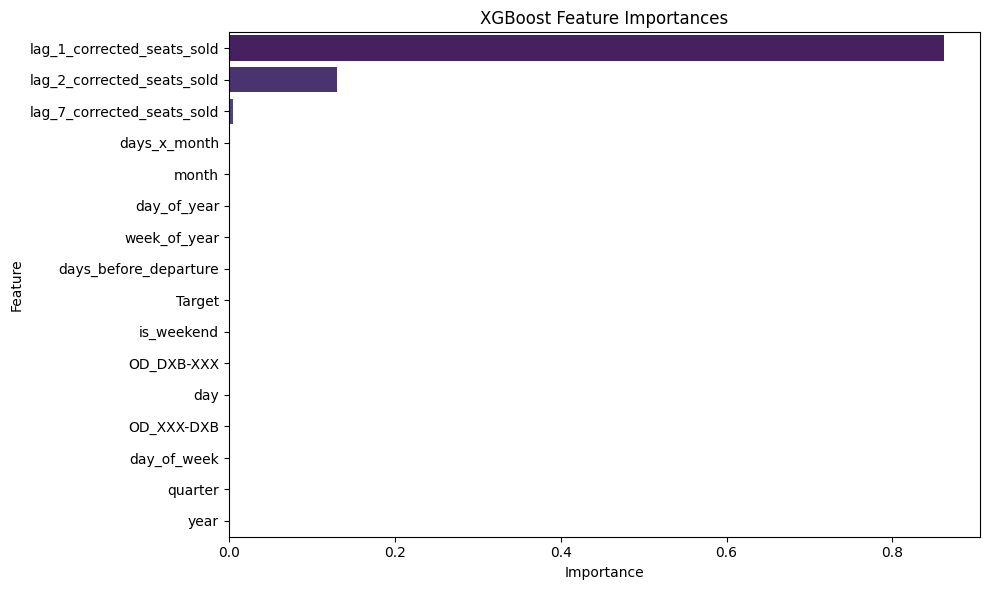

In [19]:
# --- Visualize XGBoost Feature Importance ---
print("\n--- XGBoost Feature Importance ---")
feature_importances = pd.Series(best_xgb_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [21]:

# Model Training

# X and y
features = [col for col in df_training.columns if col not in ['departure_Date', 'seats_sold','corrected_seats_sold','is_impute_candidate_flag']]
X = df_training[features]
y = df_training['corrected_seats_sold']

for col in ['OD_DXB-XXX', 'OD_XXX-DXB']:
    if col in X.columns and X[col].dtype == bool:
        X[col] = X[col].astype(int)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# XGBoost Model Training

print("Training XGBoost model...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,
                         learning_rate=0.05,
                         random_state=42,
                         n_jobs=-1,
                         eval_metric='rmse', 
                         early_stopping_rounds=50 ,
                         subsample=0.7,
                         colsample_bytree=0.9,
                         gamma=0,
                         max_depth=6
                        )

xgb_model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          verbose=False
         )

xgb_predictions = xgb_model.predict(X_val)

print("Model training complete.")

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_predictions))
xgb_mae = mean_absolute_error(y_val, xgb_predictions)
xgb_r2 = r2_score(y_val, xgb_predictions)

print(f"XGBoost RMSE: {xgb_rmse:.2f}")
print(f"XGBoost MAE: {xgb_mae:.2f}")
print(f"XGBoost R-squared: {xgb_r2:.2f}")



Training data shape: (99590, 16)
Validation data shape: (24898, 16)
Training XGBoost model...
Model training complete.
XGBoost RMSE: 4.91
XGBoost MAE: 2.19
XGBoost R-squared: 1.00


In [ ]:
import joblib 
import os   

model_dir = 'trained_models'
os.makedirs(model_dir, exist_ok=True)
joblib_model_filename = os.path.join(model_dir, 'xgb_model_joblib.pkl')
try:
    joblib.dump(xgb_model, joblib_model_filename)
    print("Model saved successfully with Joblib.")
except Exception as e:
    print(f"Error saving model with Joblib: {e}")

Model saved successfully with Joblib.


In [22]:
def feature_engineering(df, is_training=True, prev_predictions=None, od_columns_from_training=None):
    df_processed = df.copy()

    # Time-based Features
    df_processed['day_of_week'] = df_processed['departure_Date'].dt.dayofweek
    df_processed['day_of_year'] = df_processed['departure_Date'].dt.dayofyear
    df_processed['day'] = df_processed['departure_Date'].dt.day
    df_processed['month'] = df_processed['departure_Date'].dt.month
    df_processed['year'] = df_processed['departure_Date'].dt.year
    df_processed['quarter'] = df_processed['departure_Date'].dt.quarter
    df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)
    df_processed['week_of_year'] = df_processed['departure_Date'].dt.isocalendar().week.astype(int)
    df_processed['days_x_month'] = df_processed['days_before_departure'] * df_processed['month']

    if 'OD_DXB-XXX' in df.columns:
        df_processed['OD_DXB-XXX'] = df_processed['OD_DXB-XXX'].astype(int)
    if 'OD_XXX_DXB' in df_processed.columns:
        df_processed['OD_XXX_DXB'] = df_processed['OD_XXX-DXB'].astype(int)



    df_processed['lag_1_corrected_seats_sold'] = 0.0
    df_processed['lag_2_corrected_seats_sold'] = 0.0
    df_processed['lag_7_corrected_seats_sold'] = 0.0

    if not is_training and prev_predictions is not None:
        current_day_idx = df_processed['days_before_departure'].iloc[0]

        # Use shift(1) logic for "lag" meaning previous point in time (larger days_before_departure)
        # If your training used shift(-1) for lags, adjust this accordingly
        if (current_day_idx + 1) in prev_predictions: # Prev day in sequence (e.g. 341 for 340)
            df_processed['lag_1_corrected_seats_sold'] = prev_predictions[current_day_idx + 1]
        if (current_day_idx + 2) in prev_predictions:
            df_processed['lag_2_corrected_seats_sold'] = prev_predictions[current_day_idx + 2]
        if (current_day_idx + 7) in prev_predictions:
            df_processed['lag_7_corrected_seats_sold'] = prev_predictions[current_day_idx + 7]

    return df_processed

In [23]:

all_predictions_wide = []
all_predictions_long = [] 
features = ['Target','days_before_departure','OD_DXB-XXX', 'OD_XXX-DXB', 'day_of_week', 'day_of_year', 'day', 'month', 'year',
            'quarter', 'is_weekend', 'week_of_year', 'days_x_month',
            'lag_1_corrected_seats_sold', 'lag_2_corrected_seats_sold', 'lag_7_corrected_seats_sold']


# Iterate through each flight 
for index, row in output.iterrows():
    flight_departure_date = row['departure_Date']
    flight_origin_destination_str = row['Origin_Destination']
    flight_target = row['Target']

    days_to_forecast = range(342)

    sequential_predictions_for_flight = {}
    temp_long_data = [] 

    for day_idx in reversed(days_to_forecast): # Loop from 341 down to 0
        col_name = f'{day_idx}_SeatsSold_sum'
        actual_val = row.get(col_name) # Check if an actual value exists for this specific day_idx

        current_day_seats_sold = None
        value_type = None

        if pd.notna(actual_val):
            current_day_seats_sold = actual_val
            value_type = 'actual'
        else:
            # 1. Current Day df
            current_day_input_df = pd.DataFrame({
                'departure_Date': [flight_departure_date],
                'Origin_Destination': [flight_origin_destination_str],
                'Target': [flight_target],
                'days_before_departure': [day_idx]
            })

            # 2. Apply feature engineering
            current_day_features_df = feature_engineering(
                current_day_input_df,
                is_training=False, 
                prev_predictions=sequential_predictions_for_flight, 
                od_columns_from_training=['OD_DXB-XXX','OD_XXX-DXB'] 
            )

            # 3. Ensure the feature columns are in the exact order and type as the model expects.
            processed_features_for_prediction = pd.DataFrame(columns=features)
            for col in features:
                if col in current_day_features_df.columns:
                    processed_features_for_prediction[col] = current_day_features_df[col]
                else:
                    processed_features_for_prediction[col] = 0.0

            # 4. Make the prediction for this single day.
            predicted_val = xgb_model.predict(processed_features_for_prediction)[0]
            current_day_seats_sold = max(0, int(np.round(predicted_val))) # Ensure non-negative and integer
            value_type = 'predicted'

        # Store the current day's calculated seats_sold (actual or predicted) in the memory dictionary.
        sequential_predictions_for_flight[day_idx] = current_day_seats_sold

        # Append data to the long format list for the current day
        temp_long_data.append({
            'departure_Date': flight_departure_date,
            'Origin_Destination': flight_origin_destination_str,
            'Target': flight_target,
            'days_before_departure': day_idx,
            'seats_sold': current_day_seats_sold,
            'value_type': value_type
        })



    # After forecasting all days for the current flight, sort the long data
    forecasted_sales_wide = {}
    for day_idx in days_to_forecast:
        # Retrieve the final, determined value (actual or predicted) for each day_idx
        forecasted_sales_wide[f'{day_idx}_SeatsSold_sum'] = sequential_predictions_for_flight.get(day_idx)
        
    temp_long_data_sorted = sorted(temp_long_data, key=lambda x: x['days_before_departure'])
    all_predictions_long.extend(temp_long_data_sorted)

    # Append the wide format results for the current flight
    all_predictions_wide.append({
        'departure_Date': flight_departure_date,
        'Origin_Destination': flight_origin_destination_str,
        'Target': flight_target,
        **forecasted_sales_wide
    })


# Convert lists of dictionaries to DataFrames
forecasted_output_wide = pd.DataFrame(all_predictions_wide)
forecasted_output_long = pd.DataFrame(all_predictions_long)



In [50]:
forecasted_output_long

,departure_Date,Origin_Destination,Target,days_before_departure,seats_sold,value_type
0,2023-03-13 00:00:00+00:00,DXB-XXX,1004,0,208.00,predicted
1,2023-03-13 00:00:00+00:00,DXB-XXX,1004,1,208.00,predicted
2,2023-03-13 00:00:00+00:00,DXB-XXX,1004,2,208.00,predicted
3,2023-03-13 00:00:00+00:00,DXB-XXX,1004,3,208.00,predicted
4,2023-03-13 00:00:00+00:00,DXB-XXX,1004,4,208.00,predicted
...,...,...,...,...,...,...
10939,2023-09-12 00:00:00+00:00,DXB-XXX,489,337,0.00,actual
10940,2023-09-12 00:00:00+00:00,DXB-XXX,489,338,0.00,actual
10941,2023-09-12 00:00:00+00:00,DXB-XXX,489,339,0.00,actual
10942,2023-09-12 00:00:00+00:00,DXB-XXX,489,340,0.00,actual


In [ ]:
def plot_days_before_departure(df, plot_type='line'):
    """
    Generates a line graph or scatter plot of 'seats_sold' vs. 'days_before_departure',
    with coloring based on the combination of 'departure_Date' and 'Origin_Destination',
    and styling to distinguish 'actual' vs. 'predicted' values.

    Args:
        df (pd.DataFrame): The input DataFrame containing the data.
                           Expected columns: 'days_before_departure', 'seats_sold',
                           'departure_Date', 'Origin_Destination', 'value_type'.
        plot_type (str): Type of plot to generate. Can be 'line' or 'scatter'.
                         Defaults to 'line'.
    """

    # Create a combined 'Route_ID' for marker differentiation
    df['Route_ID'] = df.apply(lambda row: f"{row['departure_Date']} | {row['Origin_Destination']}", axis=1)

    plt.figure(figsize=(16, 9))

    y_label_text = 'Seats Sold'
    plot_title_suffix = '(Line Plot)' if plot_type == 'line' else '(Scatter Plot)'

 
    value_type_palette = {'actual': 'dodgerblue', 'predicted': 'darkorange'}

    if plot_type == 'line':
        sns.lineplot(
            data=df,
            x='days_before_departure',
            y='seats_sold',
            hue='value_type',       # Color based on actual/predicted
            palette=value_type_palette,
            style='Route_ID',     
            markers=True,         
            dashes=False,          
            alpha=0.8,           
            linewidth=1.5          
        )
        plt.title(f'{y_label_text} vs. Days Before Departure by Value Type and Route {plot_title_suffix}')
    elif plot_type == 'scatter':
        sns.scatterplot(
            data=df,
            x='days_before_departure',
            y='seats_sold',
            hue='value_type',       # Color based on actual/predicted
            palette=value_type_palette, 
            style='Route_ID',       
            s=80,                   
            alpha=0.8              
        )
        plt.title(f'{y_label_text} vs. Days Before Departure by Value Type and Route {plot_title_suffix}')
    else:
        print("Invalid plot_type. Please choose 'line' or 'scatter'.")
        return

    plt.xlabel('Days Before Departure')
    plt.ylabel(y_label_text)
    plt.grid(True, linestyle='--', alpha=0.6)


    plt.legend(title='Value Type & Flight Route', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout() 
    plt.show()

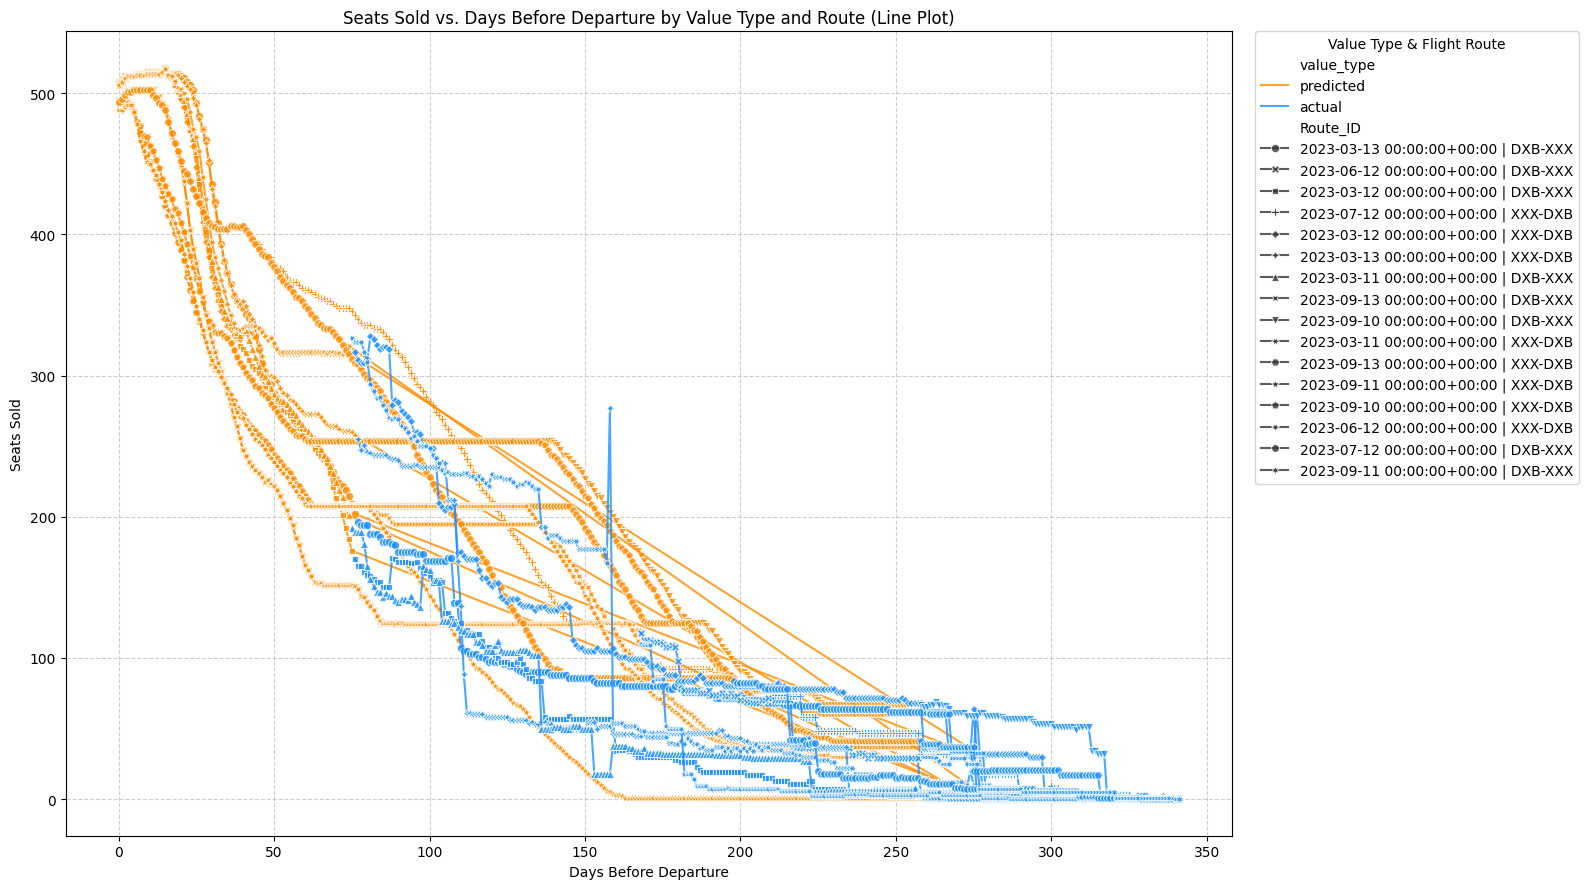

In [27]:
l = forecasted_output_long['departure_Date'].sample(10)
df_sampled = forecasted_output_long[forecasted_output_long['departure_Date'].isin(l)]
plot_days_before_departure(df_sampled, plot_type='line')

In [24]:
pd.set_option('display.max_rows', 500)
forecasted_output_long[(forecasted_output_long['departure_Date'] == '2023-03-12')&(forecasted_output_long['Origin_Destination'] == 'XXX-DXB')].sort_values(by='days_before_departure', ascending=False)

,departure_Date,Origin_Destination,Target,days_before_departure,seats_sold,value_type
2051,2023-03-12 00:00:00+00:00,XXX-DXB,990,341,0.00,actual
2050,2023-03-12 00:00:00+00:00,XXX-DXB,990,340,0.00,actual
2049,2023-03-12 00:00:00+00:00,XXX-DXB,990,339,0.00,actual
2048,2023-03-12 00:00:00+00:00,XXX-DXB,990,338,0.00,actual
2047,2023-03-12 00:00:00+00:00,XXX-DXB,990,337,0.00,actual
2046,2023-03-12 00:00:00+00:00,XXX-DXB,990,336,2.00,actual
2045,2023-03-12 00:00:00+00:00,XXX-DXB,990,335,0.00,actual
2044,2023-03-12 00:00:00+00:00,XXX-DXB,990,334,0.00,actual
2043,2023-03-12 00:00:00+00:00,XXX-DXB,990,333,0.00,actual
2042,2023-03-12 00:00:00+00:00,XXX-DXB,990,332,0.00,actual


In [25]:
forecasted_output_wide

,departure_Date,Origin_Destination,Target,0_SeatsSold_sum,1_SeatsSold_sum,2_SeatsSold_sum,3_SeatsSold_sum,4_SeatsSold_sum,5_SeatsSold_sum,6_SeatsSold_sum,7_SeatsSold_sum,8_SeatsSold_sum,9_SeatsSold_sum,10_SeatsSold_sum,11_SeatsSold_sum,12_SeatsSold_sum,13_SeatsSold_sum,14_SeatsSold_sum,15_SeatsSold_sum,16_SeatsSold_sum,17_SeatsSold_sum,18_SeatsSold_sum,19_SeatsSold_sum,20_SeatsSold_sum,21_SeatsSold_sum,22_SeatsSold_sum,23_SeatsSold_sum,24_SeatsSold_sum,25_SeatsSold_sum,26_SeatsSold_sum,27_SeatsSold_sum,28_SeatsSold_sum,29_SeatsSold_sum,30_SeatsSold_sum,31_SeatsSold_sum,32_SeatsSold_sum,33_SeatsSold_sum,34_SeatsSold_sum,35_SeatsSold_sum,36_SeatsSold_sum,37_SeatsSold_sum,38_SeatsSold_sum,39_SeatsSold_sum,40_SeatsSold_sum,41_SeatsSold_sum,42_SeatsSold_sum,43_SeatsSold_sum,44_SeatsSold_sum,45_SeatsSold_sum,46_SeatsSold_sum,47_SeatsSold_sum,48_SeatsSold_sum,49_SeatsSold_sum,50_SeatsSold_sum,51_SeatsSold_sum,52_SeatsSold_sum,53_SeatsSold_sum,54_SeatsSold_sum,55_SeatsSold_sum,56_SeatsSold_sum,57_SeatsSold_sum,58_SeatsSold_sum,59_SeatsSold_sum,60_SeatsSold_sum,61_SeatsSold_sum,62_SeatsSold_sum,63_SeatsSold_sum,64_SeatsSold_sum,65_SeatsSold_sum,66_SeatsSold_sum,67_SeatsSold_sum,68_SeatsSold_sum,69_SeatsSold_sum,70_SeatsSold_sum,71_SeatsSold_sum,72_SeatsSold_sum,73_SeatsSold_sum,74_SeatsSold_sum,75_SeatsSold_sum,76_SeatsSold_sum,77_SeatsSold_sum,78_SeatsSold_sum,79_SeatsSold_sum,80_SeatsSold_sum,81_SeatsSold_sum,82_SeatsSold_sum,83_SeatsSold_sum,84_SeatsSold_sum,85_SeatsSold_sum,86_SeatsSold_sum,87_SeatsSold_sum,88_SeatsSold_sum,89_SeatsSold_sum,90_SeatsSold_sum,91_SeatsSold_sum,92_SeatsSold_sum,93_SeatsSold_sum,94_SeatsSold_sum,95_SeatsSold_sum,96_SeatsSold_sum,97_SeatsSold_sum,98_SeatsSold_sum,99_SeatsSold_sum,100_SeatsSold_sum,101_SeatsSold_sum,102_SeatsSold_sum,103_SeatsSold_sum,104_SeatsSold_sum,105_SeatsSold_sum,106_SeatsSold_sum,107_SeatsSold_sum,108_SeatsSold_sum,109_SeatsSold_sum,110_SeatsSold_sum,111_SeatsSold_sum,112_SeatsSold_sum,113_SeatsSold_sum,114_SeatsSold_sum,115_SeatsSold_sum,116_SeatsSold_sum,117_SeatsSold_sum,118_SeatsSold_sum,119_SeatsSold_sum,120_SeatsSold_sum,121_SeatsSold_sum,122_SeatsSold_sum,123_SeatsSold_sum,124_SeatsSold_sum,125_SeatsSold_sum,126_SeatsSold_sum,127_SeatsSold_sum,128_SeatsSold_sum,129_SeatsSold_sum,130_SeatsSold_sum,131_SeatsSold_sum,132_SeatsSold_sum,133_SeatsSold_sum,134_SeatsSold_sum,135_SeatsSold_sum,136_SeatsSold_sum,137_SeatsSold_sum,138_SeatsSold_sum,139_SeatsSold_sum,140_SeatsSold_sum,141_SeatsSold_sum,142_SeatsSold_sum,143_SeatsSold_sum,144_SeatsSold_sum,145_SeatsSold_sum,146_SeatsSold_sum,147_SeatsSold_sum,148_SeatsSold_sum,149_SeatsSold_sum,150_SeatsSold_sum,151_SeatsSold_sum,152_SeatsSold_sum,153_SeatsSold_sum,154_SeatsSold_sum,155_SeatsSold_sum,156_SeatsSold_sum,157_SeatsSold_sum,158_SeatsSold_sum,159_SeatsSold_sum,160_SeatsSold_sum,161_SeatsSold_sum,162_SeatsSold_sum,163_SeatsSold_sum,164_SeatsSold_sum,165_SeatsSold_sum,166_SeatsSold_sum,167_SeatsSold_sum,168_SeatsSold_sum,169_SeatsSold_sum,170_SeatsSold_sum,171_SeatsSold_sum,172_SeatsSold_sum,173_SeatsSold_sum,174_SeatsSold_sum,175_SeatsSold_sum,176_SeatsSold_sum,177_SeatsSold_sum,178_SeatsSold_sum,179_SeatsSold_sum,180_SeatsSold_sum,181_SeatsSold_sum,182_SeatsSold_sum,183_SeatsSold_sum,184_SeatsSold_sum,185_SeatsSold_sum,186_SeatsSold_sum,187_SeatsSold_sum,188_SeatsSold_sum,189_SeatsSold_sum,190_SeatsSold_sum,191_SeatsSold_sum,192_SeatsSold_sum,193_SeatsSold_sum,194_SeatsSold_sum,195_SeatsSold_sum,196_SeatsSold_sum,197_SeatsSold_sum,198_SeatsSold_sum,199_SeatsSold_sum,200_SeatsSold_sum,201_SeatsSold_sum,202_SeatsSold_sum,203_SeatsSold_sum,204_SeatsSold_sum,205_SeatsSold_sum,206_SeatsSold_sum,207_SeatsSold_sum,208_SeatsSold_sum,209_SeatsSold_sum,210_SeatsSold_sum,211_SeatsSold_sum,212_SeatsSold_sum,213_SeatsSold_sum,214_SeatsSold_sum,215_SeatsSold_sum,216_SeatsSold_sum,217_SeatsSold_sum,218_SeatsSold_sum,219_SeatsSold_sum,220_SeatsSold_sum,221_SeatsSold_sum,222_SeatsSold_sum,223_SeatsSold_sum,224_SeatsSold_sum,225_SeatsSold_sum,